In [1]:
%matplotlib inline
import pyross
import numpy as np
import matplotlib.pyplot as plt

# Introduction: Forecast for SEIR model with stochastic parameters

In this notebook, we consider the SEIR model. 

We assume that the parameters 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact),
* $\gamma_{I_a}$ (rate of removal for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of removal for ymptomatic infected individuals) 
* $\gamma_{E}$ (rate of progression for exposed individual), 

are not known exactly, but rather are characterized by a 5D Gaussian distribution with known mean and covariance matrix. The Gaussian distribution is trunacted, i.e. set to zero if any parameter is $\leq 0$.

**We now illustrate how uncertainties in the parameters listed above affect the predictions of the SIR model.**

For this we simulate the SEIR model $N_s = 200$ times; for each simulation the parameters are sampled from the given Gaussian distribution. The resulting 200 trajectories are shown together with their mean, standard deviation, median, and 5 as well as 95 percentiles.

We perform this analysis for 

1. the deterministic SEIR model,
2. the stochastic SEIR model (simulated with a Gillespie SSA algorithm), and
3. the stochastic SEIR model (simulated with a tau-leaping algorithm).

# Define model parameters and initialise pyross.forecast.SEIR

In [2]:
M = 1                  # the SEIR model has no age structure
Ni = 50000*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

fsa   = 1              # the self-isolation parameter 

Ia0 = np.array([0])     # the SEIR model we consider has only one kind of infective 
Is0 = np.array([500])    # we take these to be symptomatic 
R0  = np.array([0])     # and assume there are no recovered individuals initially 
E0 = np.array([0])      # as well as no exposed
S0  = N-(E0+Ia0+Is0+R0)    # so that the initial susceptibles are obtained from S + E + Ia + Is + R = N

# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

# duration of simulation and output datapoints
Tf = 100;  Nt=Tf+1



# These are the parameters that we sample stochastically
# means
alpha = 0.1
beta  = 0.5            # infection rate
gIa = 1/14.           # removal rate 
gIs = 1/14.           # removal rate 
gE = 0.1              # rate of progression from exposed to infective

#
cov = np.zeros([5,5],dtype=float)
cov[0,0] = 0.0*alpha**2 # cov(alpha, alpha)
cov[1,1] = 0.01*beta**2 # cov(beta, beta)
cov[2,2] = 0.01*gIa**2 # cov(gIa, gIa)
cov[3,3] = 0.01*gIs**2 # cov(gIs, gIs)
cov[4,4] = 0.01*gE**2 # cov(gE, gE)
#
cov[1,4] = 0.001*beta*gE # cov(beta, gE)
cov[1,2] = 0.001*beta*gIa # cov(beta, gIa)
cov[1,3] = 0.001*beta*gIa # cov(beta, gIs)
cov[4,1] = cov[1,4]
cov[2,1] = cov[1,2] # covariance matrix 
cov[3,1] = cov[1,3] # is symmetric
#
cov[2,3] = cov[2,2] # cov(gIa, gIs)
cov[3,2] = cov[2,3] 
# setting cov(gIa, gIs) = cov(gIa, gIa) means that 
# we assume gIa and gIs to be equal, as
# will be visualised below


# Define parameters for simulations
parameters = {'alpha':alpha, 'beta':beta,'fsa':fsa,
              'gE':gE,
             'gIa':gIa,'gIs':gIs,
             'cov':cov,
                }

# Initialise pyross forecast module
model_forecast = pyross.forecast.SEIR(parameters, M, Ni)

# Number of simulations over which we average, use 200
Ns = 10 

In [6]:
help(pyross.forecast)

Help on module pyross.forecast in pyross:

NAME
    pyross.forecast

CLASSES
    builtins.object
        SEAIRQ
        SEAIRQ_latent
        SEIR
        SEIR_latent
        SIR
        SIR_latent
    
    class SEAIRQ(builtins.object)
     |  Susceptible, Exposed, Infected, Removed (SEIR)
     |  Ia: asymptomatic
     |  Is: symptomatic
     |  A: Asymptomatic and infectious 
     |  Parameters
     |  ----------
     |  parameters: dict
     |      Contains the following keys:
     |          alpha: float
     |              Estimate mean value of fraction of infected who are asymptomatic.
     |          beta: float
     |              Estimate mean value of rate of spread of infection.
     |          gIa: float
     |              Estimate mean value of rate of removal from asymptomatic individuals.
     |          gIs: float
     |              Estimate mean value of rate of removal from symptomatic individuals.
     |          fsa: float
     |              fraction by which sy

In [3]:
# Define a function which we use below to plot simulation results
def plot_trajectories(result,
                percentile=-1,
                plot_index = 3, # which time series should be plotted? 
               filename='None'): # set filename for saving figures
    # plot_index = 0: susceptibles
    # plot_index = 1: infectives, asymptomatic
    # plot_index = 2: infectives, symptomatic
    if plot_index == 0:
        ylabel = r'$N_S$'
    elif plot_index == 1:
        ylabel = r'$N_{E}$'
    elif plot_index == 2:
        ylabel = r'$N_{I,a}$'
    elif plot_index == 3:
        ylabel = r'$N_{I,s}$'
    else:
        raise RuntimeError("plot_index should be 0, 1, 2, or 3.")
    #
    fontsize=25
    #
    #
    trajectories = result['X']
    t_arr = result['t']
    traj_mean = result['X_mean']
    traj_std = result['X_std']
    #
    #
    # Plot trajectories
    #
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(r'Simulation results for stochastic $\beta$, $\gamma$',
                 y=1.05,
                fontsize=fontsize)
    for i,e in enumerate(trajectories):
        ax.plot(t_arr,e[plot_index],
                alpha=0.15,
               )
    ax.fill_between(t_arr,traj_mean[plot_index] - traj_std[plot_index],
                    traj_mean[plot_index] + traj_std[plot_index],
                    alpha=0.7,
                    color='limegreen',
                           label='Std deviation')
    ax.plot(t_arr,traj_mean[plot_index] - traj_std[plot_index],
                    alpha=1,
            label='Std deviation',
            lw=1.5,
            ls='--',
                    color='black')
    ax.plot(t_arr,traj_mean[plot_index] + traj_std[plot_index],
                    alpha=1,
            #label='Std deviation',
            lw=1.5,
            ls='--',
                    color='black')
    ax.plot(t_arr,traj_mean[plot_index],
                    alpha=1,
            lw=2,
            color='black',
           label='Mean')
    ax.set_xlim(np.min(t_arr),np.max(t_arr))
    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
    ax.legend(loc='upper right',fontsize=18)
    plt.show()
    if filename != 'None':
        fig.savefig(filename + '_trajs.png', bbox_inches='tight',dpi=100)
    plt.close()
    #
    #
    #
    # Plot percentiles
    #
    if percentile > 0:
        percentiles_lower = np.percentile(trajectories[:,plot_index],percentile,axis=0)
        percentiles_upper = np.percentile(trajectories[:,plot_index],100-percentile,axis=0)
        percentiles_median = np.percentile(trajectories[:,plot_index],50,axis=0)
        print("In the following plot, red dashed lines denote {0} and {1} percentiles of the numerical data:".format(percentile,
                                                                                             100-percentile))
        fig, ax = plt.subplots(1,1,figsize=(7,5))
        ax.set_title(r'Simulation results for stochastic $\beta$, $\gamma$',
                     y=1.05,
                    fontsize=fontsize)
        for i,e in enumerate(trajectories):
            ax.plot(t_arr,e[plot_index],
                    alpha=0.15,
                   )
        ax.fill_between(t_arr,percentiles_lower,
                        percentiles_upper,
                        alpha=0.1,
                        color='red',
                               label='Percentiles')
        ax.plot(t_arr,percentiles_lower,
                        alpha=1,
                lw=2,
                label='Percentiles',
                ls='--',
                color='red',
               )
        ax.plot(t_arr,percentiles_upper,
                        alpha=1,
                lw=2,
                color='red',
                ls='--',
               )
        ax.plot(t_arr,percentiles_median,
                        alpha=1,
                lw=2,
                color='red',
               label='Median')
        ax.plot(t_arr,traj_mean[plot_index],
                        alpha=1,
                lw=2,
                color='black',
               label='Mean')
        ax.set_xlim(np.min(t_arr),np.max(t_arr))
        ax.set_ylabel(ylabel,fontsize=fontsize)
        ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
        ax.legend(loc='upper right',fontsize=18)
        plt.show()
        if filename != 'None':
            fig.savefig(filename + '_trajs2.png', bbox_inches='tight',dpi=100)
        plt.close()
        
        
# Define a function which we use below to plot parameters used for simulations
def plot_sample_parameters(result,
               filename='None'): # set filename for saving figures
    #
    fontsize=25
    #
    # Scatterplot of used parameters
    #
    sample_parameters = result['sample_parameters'].T
    beta = result['beta']
    gE = result['gE']
    gIa = result['gIa']
    gIs = result['gIs']
    #
    title = r'Samples for stochastic $\beta$, $\gamma_{E}$'
    labelx = r'$\beta $'
    labely = r'$\gamma_{E}$'
    x_mean = beta
    y_mean = gE
    labelx_mean = r'$\langle \beta \rangle$'
    labely_mean = r'$\langle \gamma_{E} \rangle$'
    data_index_x = 1
    data_index_y = 4
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(title,y=1.05,fontsize=fontsize)
    ax.axvline(x_mean,color='limegreen',ls='--',lw=2,label=labelx_mean)
    ax.axhline(y_mean,color='dodgerblue',ls='--',lw=2,label=labely_mean)
    ax.scatter(sample_parameters[data_index_x], sample_parameters[data_index_y] ,
               label='sampled data',
               color='black',s=10) #, c = truth)
    ax.set_xlabel(labelx,fontsize=fontsize)
    ax.set_ylabel(labely,fontsize=fontsize)
    ax.set_xlim(0,1.05*np.max(sample_parameters[data_index_x]))
    ax.set_ylim(0,1.05*np.max(sample_parameters[data_index_y]))
    ax.legend(loc='best',fontsize=15)
    plt.show()
    if filename != 'None':
        fig.savefig(filename + '_samples1.png', bbox_inches='tight',dpi=100)
    plt.close()
    #
    #
    title = r'Samples for stochastic $\beta$, $\gamma_{I_s}$'
    labelx = r'$\beta $'
    labely = r'$\gamma_{I_s}$'
    x_mean = beta
    y_mean = gIs
    labelx_mean = r'$\langle \beta \rangle$'
    labely_mean = r'$\langle \gamma_{I_a} \rangle$'
    data_index_x = 1
    data_index_y = 2
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(title,y=1.05,fontsize=fontsize)
    ax.axvline(x_mean,color='limegreen',ls='--',lw=2,label=labelx_mean)
    ax.axhline(y_mean,color='dodgerblue',ls='--',lw=2,label=labely_mean)
    ax.scatter(sample_parameters[data_index_x], sample_parameters[data_index_y] ,
               label='sampled data',
               color='black',s=10) #, c = truth)
    ax.set_xlabel(labelx,fontsize=fontsize)
    ax.set_ylabel(labely,fontsize=fontsize)
    ax.set_xlim(0,1.05*np.max(sample_parameters[data_index_x]))
    ax.set_ylim(0,1.05*np.max(sample_parameters[data_index_y]))
    ax.legend(loc='best',fontsize=15)
    plt.show()
    if filename != 'None':
        fig.savefig(filename + '_samples2.png', bbox_inches='tight',dpi=100)
    plt.close()
    #
    #
    title = r'Samples for stochastic $\gamma_{E}$, $\gamma_{I_s}$'
    labelx = r'$\gamma_{E} $'
    labely = r'$\gamma_{I_s}$'
    x_mean = gE
    y_mean = gIs
    labelx_mean = r'$\langle \gamma_{E} \rangle$'
    labely_mean = r'$\langle \gamma_{I_s} \rangle$'
    data_index_x = 4
    data_index_y = 3
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(title,y=1.05,fontsize=fontsize)
    ax.axvline(x_mean,color='limegreen',ls='--',lw=2,label=labelx_mean)
    ax.axhline(y_mean,color='dodgerblue',ls='--',lw=2,label=labely_mean)
    ax.scatter(sample_parameters[data_index_x], sample_parameters[data_index_y] ,
               label='sampled data',
               color='black',s=10) #, c = truth)
    ax.set_xlabel(labelx,fontsize=fontsize)
    ax.set_ylabel(labely,fontsize=fontsize)
    ax.set_xlim(0,1.05*np.max(sample_parameters[data_index_x]))
    ax.set_ylim(0,1.05*np.max(sample_parameters[data_index_y]))
    ax.legend(loc='best',fontsize=15)
    plt.show()
    if filename != 'None':
        fig.savefig(filename + '_samples3.png', bbox_inches='tight',dpi=100)
    plt.close()
    #

# 1. Forecast based on deterministic model

Finished. Time needed for evaluation: 00:00:00


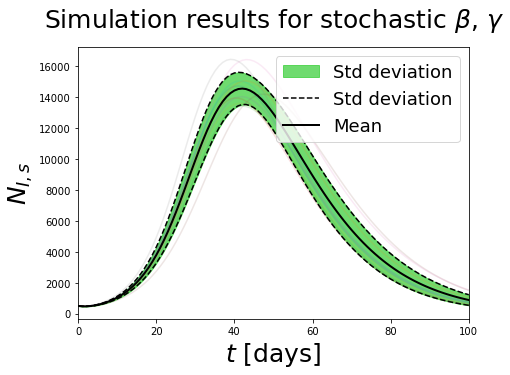

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


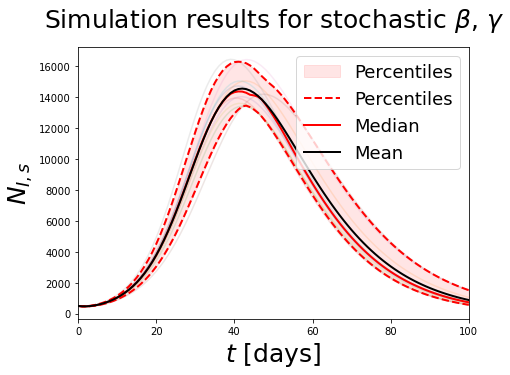

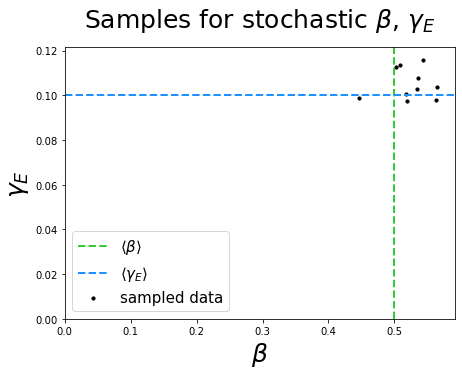

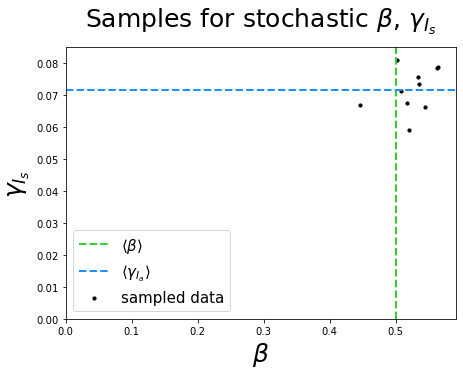

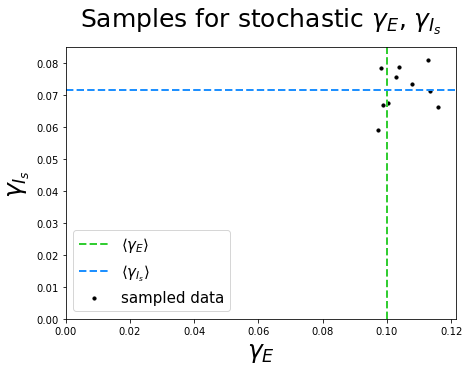

In [4]:
result = model_forecast.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nt,
                                      verbose=True,
                                     Ns=Ns) 

plot_trajectories(result,
#            filename='forecast_deterministic',
            percentile=5,
           )

plot_sample_parameters(result)

# 2. Forecast based on stochastic Gillespie SSA algorithm

Finished. Time needed for evaluation: 00:00:23


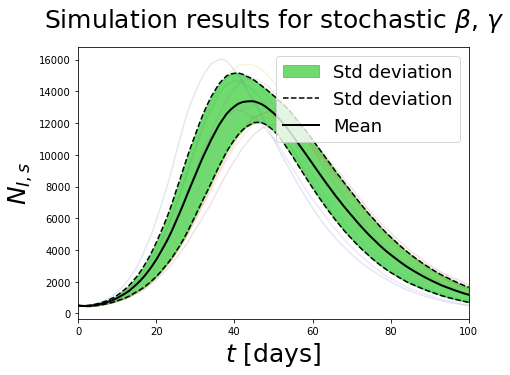

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


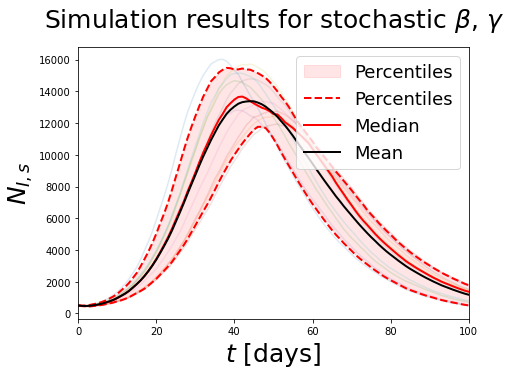

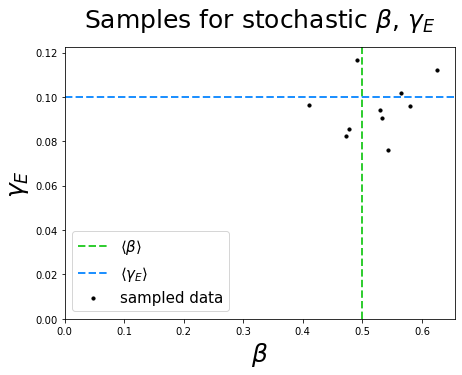

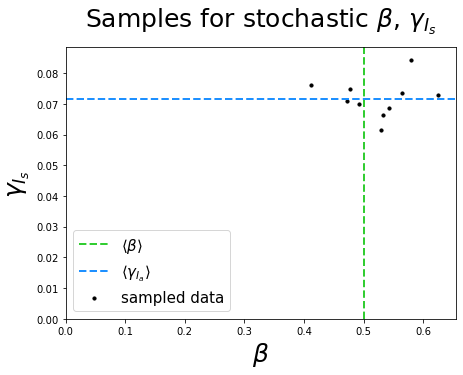

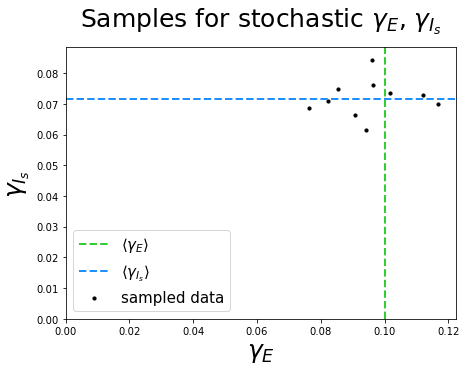

In [5]:
# This may take a while
result = model_forecast.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nt,
                                      verbose=True,
                                     method='gillespie',
                                     Ns=Ns) 

plot_trajectories(result,
#            filename='forecast_deterministic',
            percentile=5,
           )

plot_sample_parameters(result)

# 3. Forecast based on stochastic tau-leaping algorithm

Finished. Time needed for evaluation: 00:00:01


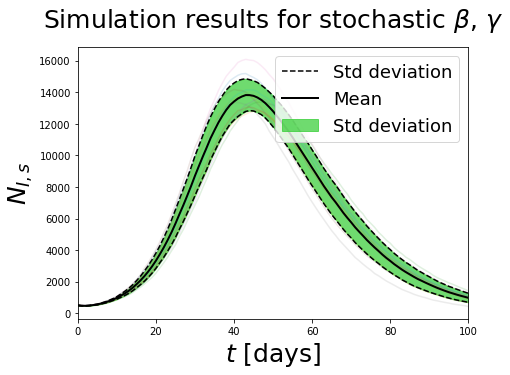

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


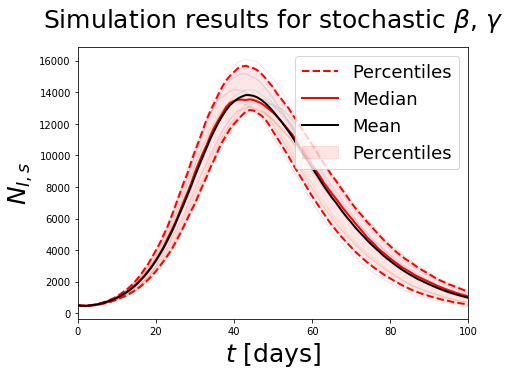

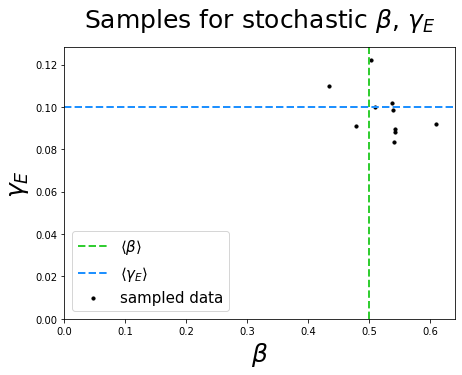

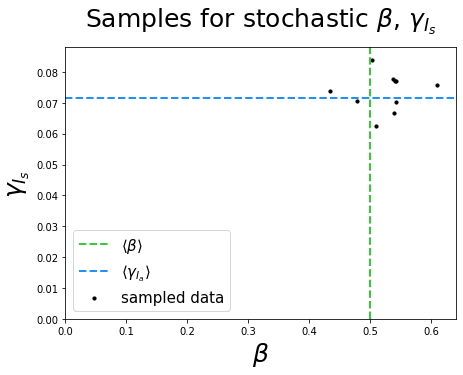

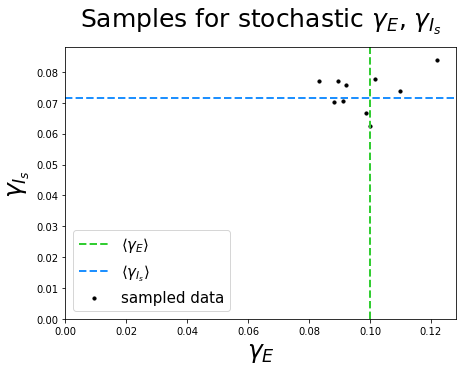

In [6]:
result = model_forecast.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nt,
                                      verbose=True,
                                     method='tau-leaping',
                                     Ns=Ns)

plot_trajectories(result,
#            filename='forecast_deterministic',
            percentile=5,
           )

plot_sample_parameters(result)

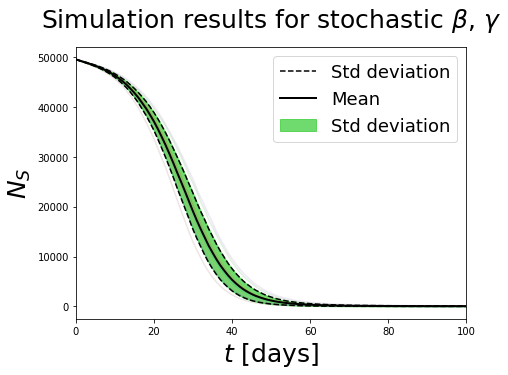

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


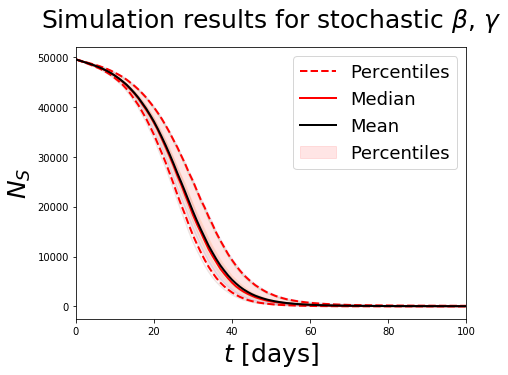

In [7]:
# For the stochastic tau-leaping algorithm, we also plot the time series for 
# the number of susceptibles

plot_trajectories(result,
#            filename='forecast_deterministic',
            plot_index =0,
            percentile=5,
           )